# Implementing and Exploring Variational Autoencoders (VAEs)




## Part 1: Setup
### Import necessary libraries

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

### Load MNIST dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.14MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.14MB/s]


## Part 2: Explore and visualize data
## Visualize samples

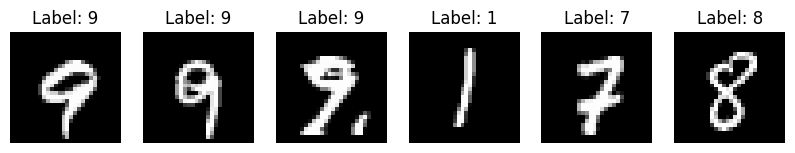

In [3]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 6, figsize=(10, 3))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Label: {labels[i].item()}')
plt.show()

## Part 3: Implement VAE



In [ ]:
import torch
from torch import nn

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
        )
        self.mu = nn.Linear(400, latent_dim)
        self.log_var = nn.Linear(400, latent_dim)

    def forward(self, x):
        h = self.enc(x)
        return self.mu(h), self.log_var(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid(),
        )

    def forward(self, z):
        return self.dec(z)

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder(z)
        return recon_x, mu, log_var



A Variational Autoencoder loss typically has two components:
  - Reconstruction loss
  - Measures how accurately the model reconstructs the input.
  - Typically binary cross-entropy for MNIST (pixel intensities are between 0 and 1). Also consider MSE.

KL Divergence loss
  - Measures how much the learned latent distribution deviates from a standard Gaussian distribution.
  - Ensures latent space regularity.

In [ ]:
def vae_loss(recon_x, x, mu, log_var):
    # Reconstruction Loss:

    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence Loss:

    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss combines both terms
    loss = recon_loss + kl_loss

    return loss, recon_loss, kl_loss


In [6]:
# The code runs faster if you run on GPU. Select Runtime -> Change runtime type -> T4 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Part 4: Train the model



In [15]:
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 15
train_losses = []
kl_losses = []
recon_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_kl = 0
    total_recon = 0
    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)
        optimizer.zero_grad()

        # Compute model predictions
        recon_x, mu, log_var = model(x)

        # Compute losses
        loss, recon_loss, kl_loss = vae_loss(recon_x, x, mu, log_var)

        # Run backward and optimizer
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    # Compute average loss and store it
    train_losses.append(total_loss / len(train_loader))
    recon_losses.append(total_recon / len(train_loader))
    kl_losses.append(total_kl / len(train_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')


Epoch [1/15], Loss: 24209.0621
Epoch [2/15], Loss: 21516.2268
Epoch [3/15], Loss: 20892.3318
Epoch [4/15], Loss: 20569.4659
Epoch [5/15], Loss: 20349.3362
Epoch [6/15], Loss: 20194.0784
Epoch [7/15], Loss: 20066.6129
Epoch [8/15], Loss: 19953.1761
Epoch [9/15], Loss: 19866.4161
Epoch [10/15], Loss: 19788.2998
Epoch [11/15], Loss: 19710.1637
Epoch [12/15], Loss: 19652.6452
Epoch [13/15], Loss: 19591.3147
Epoch [14/15], Loss: 19534.2391
Epoch [15/15], Loss: 19482.1031


# Part 5: Analyze Results

 The model converges, as we can see in the "Total VAE Training Loss" plot, Reconstruction Loss starts from an initial point and gradually flattens out over time, which shows convergence.

 As we can see in the plot, Reconstruction Loss dominates and has more weight in overall loss, while KL Divergence Loss has a smaller weight and lower influence in overall loss.



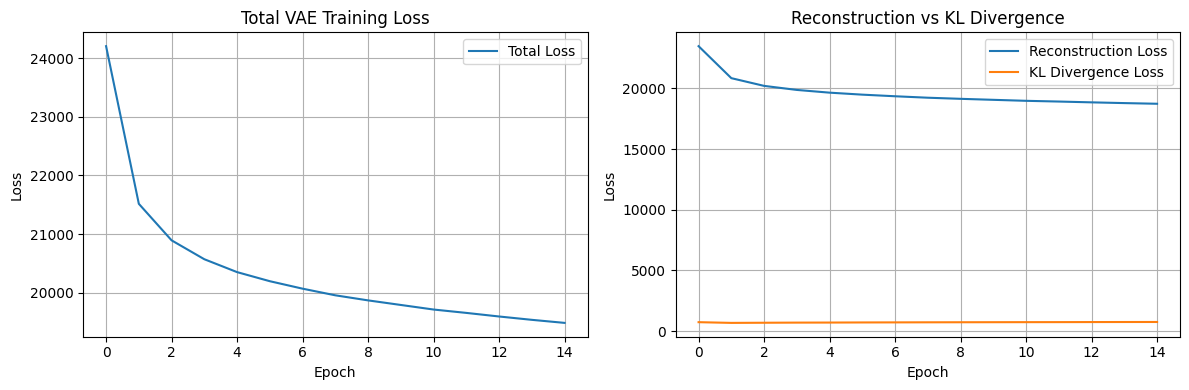

In [16]:
# Assume train_losses, recon_losses, kl_losses were stored during training

plt.figure(figsize=(12,4))

# Plot total training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Total Loss')
plt.title('Total VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Plot Reconstruction and KL divergence separately
plt.subplot(1, 2, 2)
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence Loss')
plt.title('Reconstruction vs KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


# Part 6: Generate and visualize samples

 - Is there any way that you can increase the sample qualities?
    - Can you make changes to the architecture to improve the quality?

    Yes, we can add more layers to the neural network or use convolutional layers instead of linear ones to help model capture more complex features.
    - Can you change the reconstruction loss to improve the quality?

    In this case that the MNIST images are binary like(black and white) Binary Cross Entropy aligns well with the data distribution and its the best choice here.
    but for example we can assume that loss = recon_loss + β * kl_loss and we can do the process for different values of beta.


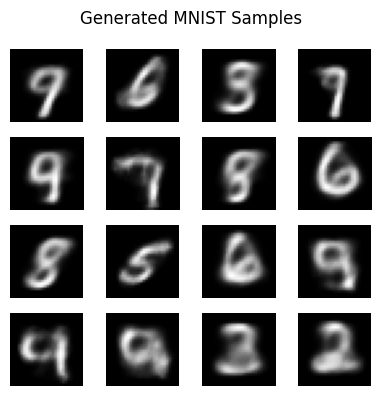

In [17]:
with torch.no_grad():
    # Generate random latent vectors
    z = torch.randn(16, model.encoder.mu.out_features).to(device)
    samples = model.decoder(z).cpu()

fig, axes = plt.subplots(4,4, figsize=(4,4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].view(28,28), cmap='gray')
    ax.axis('off')

plt.suptitle('Generated MNIST Samples')
plt.tight_layout()
plt.show()


# Part 7: Latent Space Visualization





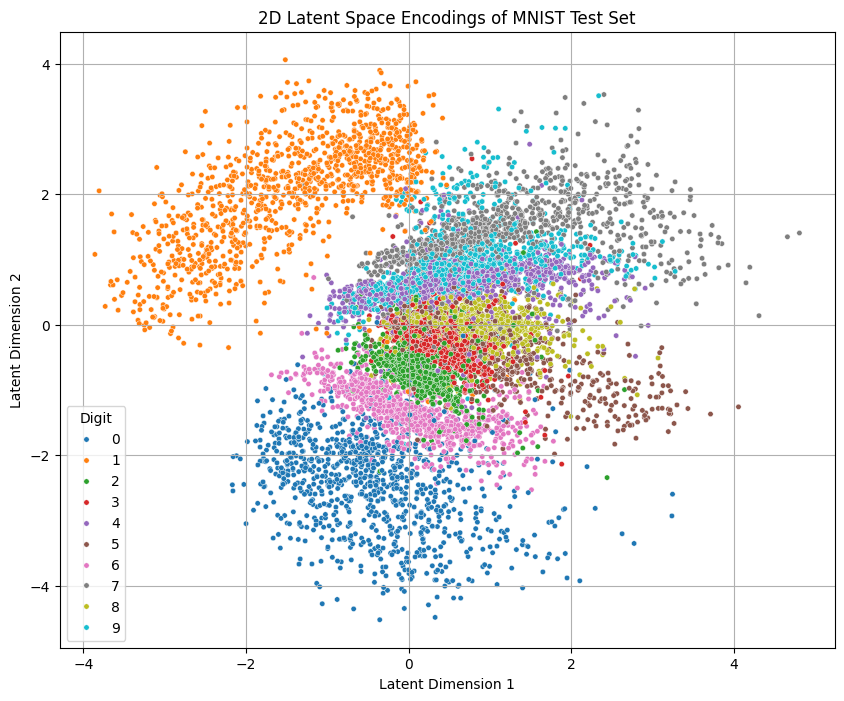

In [18]:
model.eval()
latents, labels_list = [], []

with torch.no_grad():
    for x, labels in test_loader:
        x = x.view(-1, 784).to(device)  # Correct shape for convolutional model
        # TODO: encode samples and store
        mu, log_var = model.encoder(x)
        z = model.reparameterize(mu, log_var)
        latents.append(z.cpu())
        labels_list.append(labels)

latents = torch.cat(latents, dim=0)
labels_list = torch.cat(labels_list, dim=0)

# TODO: visualize the decoded samples

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(x=latents[:, 0], y=latents[:, 1], hue=labels_list, palette='tab10', s=15, legend='full')
plt.title("2D Latent Space Encodings of MNIST Test Set")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend(title='Digit')
plt.grid(True)
plt.show()


# Part 8: Latent Space Interpolation


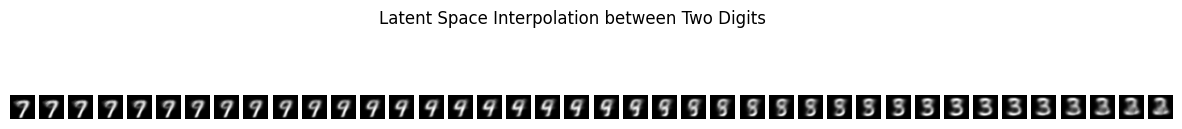

In [24]:
def interpolate(latent1, latent2, steps):
    ratios = torch.linspace(0, 1, steps).unsqueeze(1).to(latent1.device)
    interpolated = latent1 * (1 - ratios) + latent2 * ratios
    return interpolated

num_steps = 40

with torch.no_grad():
    # Select two random images
    x1 = None # select a sample from dataset
    x2 = None # select another sample from dataset

    for x, labels in test_loader:
      for i in range(x.size(0)):
          if labels[i].item() == 7 and x1 is None:
              x1 = x[i].view(1, -1).to(device)
          elif labels[i].item() == 2 and x2 is None:
              x2 = x[i].view(1, -1).to(device)
          if x1 is not None and x2 is not None:
              break
      if x1 is not None and x2 is not None:
          break

    # encode both samples using the model's encoder
    x1_encoded = model.encoder(x1)
    x2_encoded = model.encoder(x2)
    # then create interpolated encodings between both encodings
    interpolated_encodings = interpolate(x1_encoded[0], x2_encoded[0], num_steps)
    # decode the interpolated encodings to create the images
    decoded_images = model.decoder(interpolated_encodings)

fig, axes = plt.subplots(1, num_steps, figsize=(15,2))
for i, ax in enumerate(axes):
    ax.imshow(decoded_images[i].view(28,28), cmap='gray')
    ax.axis('off')

plt.suptitle('Latent Space Interpolation between Two Digits')
plt.show()
